# Youtube Trending Video Analysis

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import datetime

import warnings
from collections import Counter
import datetime
import wordcloud
import json
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score

**To improve visualization of the graphs**

In [ ]:
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)



**Reading the datasets**

In [ ]:
df =pd.read_csv("/content/INvideos.csv")
print(df.head())
print(df.describe())
print(df.info())

      video_id trending_date  \
0  kzwfHumJyYc      17.14.11   
1  zUZ1z7FwLc8      17.14.11   
2  10L1hZ9qa58      17.14.11   
3  N1vE8iiEg64      17.14.11   
4  kJzGH0PVQHQ      17.14.11   

                                               title    channel_title  \
0  Sharry Mann: Cute Munda ( Song Teaser) | Parmi...  Lokdhun Punjabi   
1  पीरियड्स के समय, पेट पर पति करता ऐसा, देखकर दं...          HJ NEWS   
2  Stylish Star Allu Arjun @ ChaySam Wedding Rece...             TFPC   
3                     Eruma Saani | Tamil vs English      Eruma Saani   
4  why Samantha became EMOTIONAL @ Samantha naga ...       Filmylooks   

   category_id              publish_time  \
0            1  2017-11-12T12:20:39.000Z   
1           25  2017-11-13T05:43:56.000Z   
2           24  2017-11-12T15:48:08.000Z   
3           23  2017-11-12T07:08:48.000Z   
4           24  2017-11-13T01:14:16.000Z   

                                                tags    views  likes  \
0  sharry mann|"sharry mann new

In [ ]:
df[df["description"].apply(lambda x: pd.isna(x))].head(3)
df["description"] = df["description"].fillna(value="")
df["trending_date"].apply(lambda x: '20' + x[:2]).value_counts(normalize=True)

,proportion
trending_date,
2018,0.76
2017,0.24


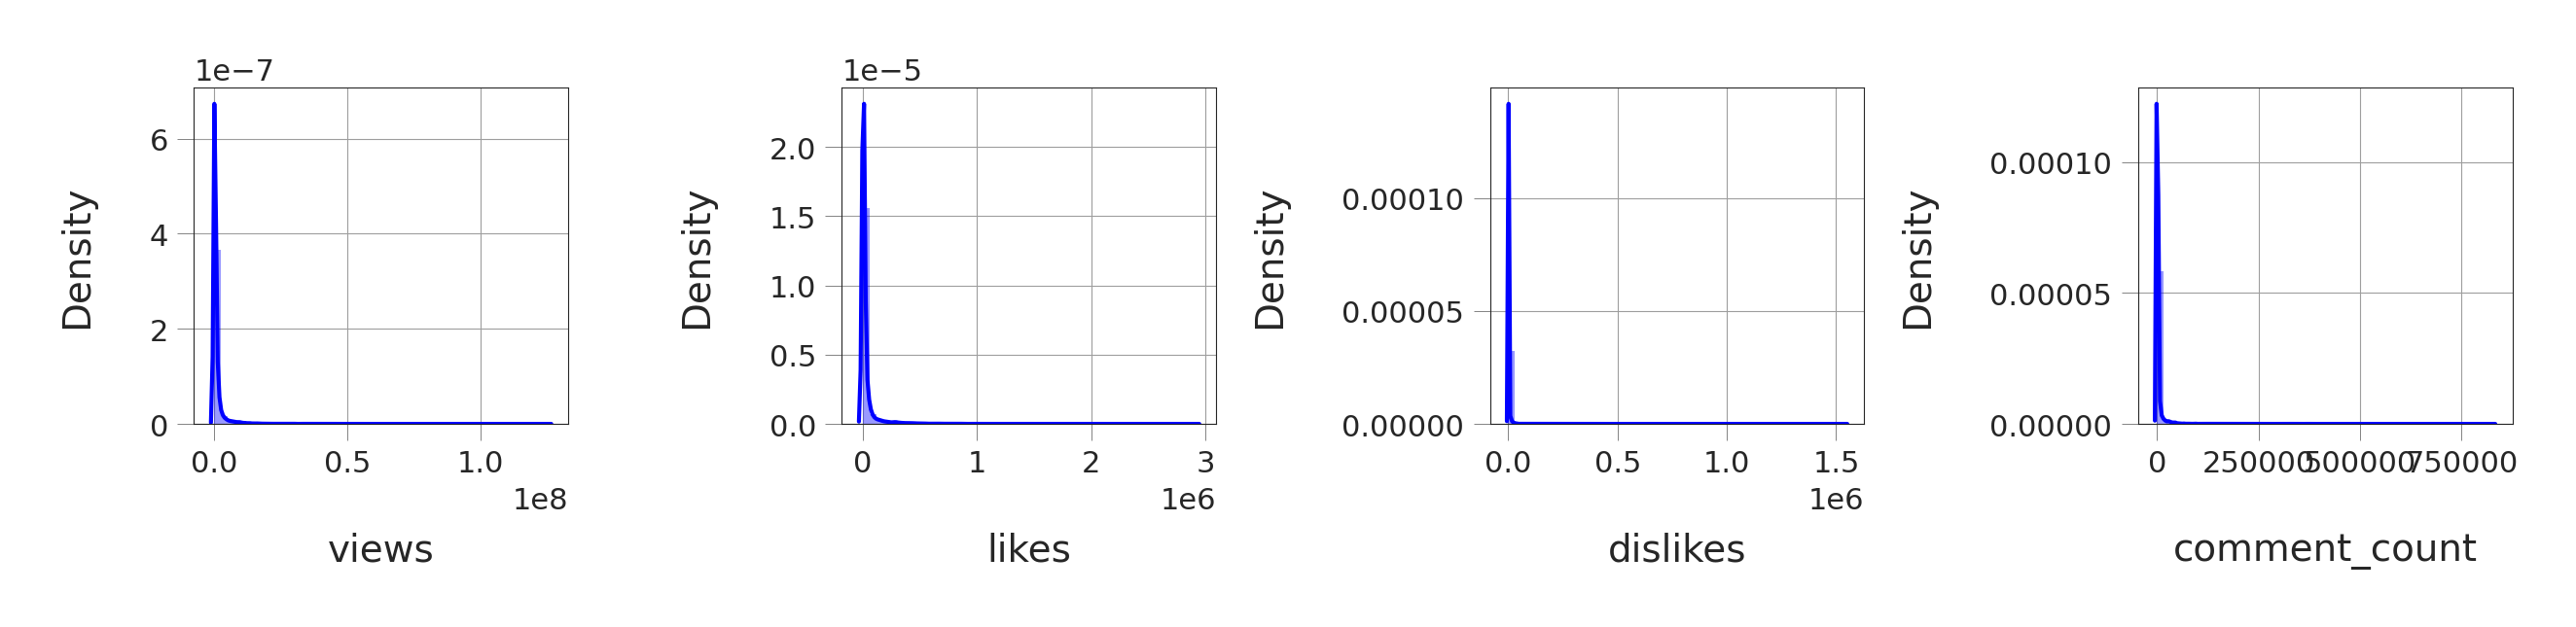

In [ ]:
sub1=["views","likes","dislikes","comment_count"]
plt.figure(figsize=(13, 3))
for i in range(0, len(sub1)):
    plt.subplot(1, 4, i+1)
    sns.distplot(df[sub1[i]], color='blue')
    plt.tight_layout()

Percentage of video having views less than 1.5m : 86.19083315485115
Percentage of video having likes less than 100k : 94.06725208824159


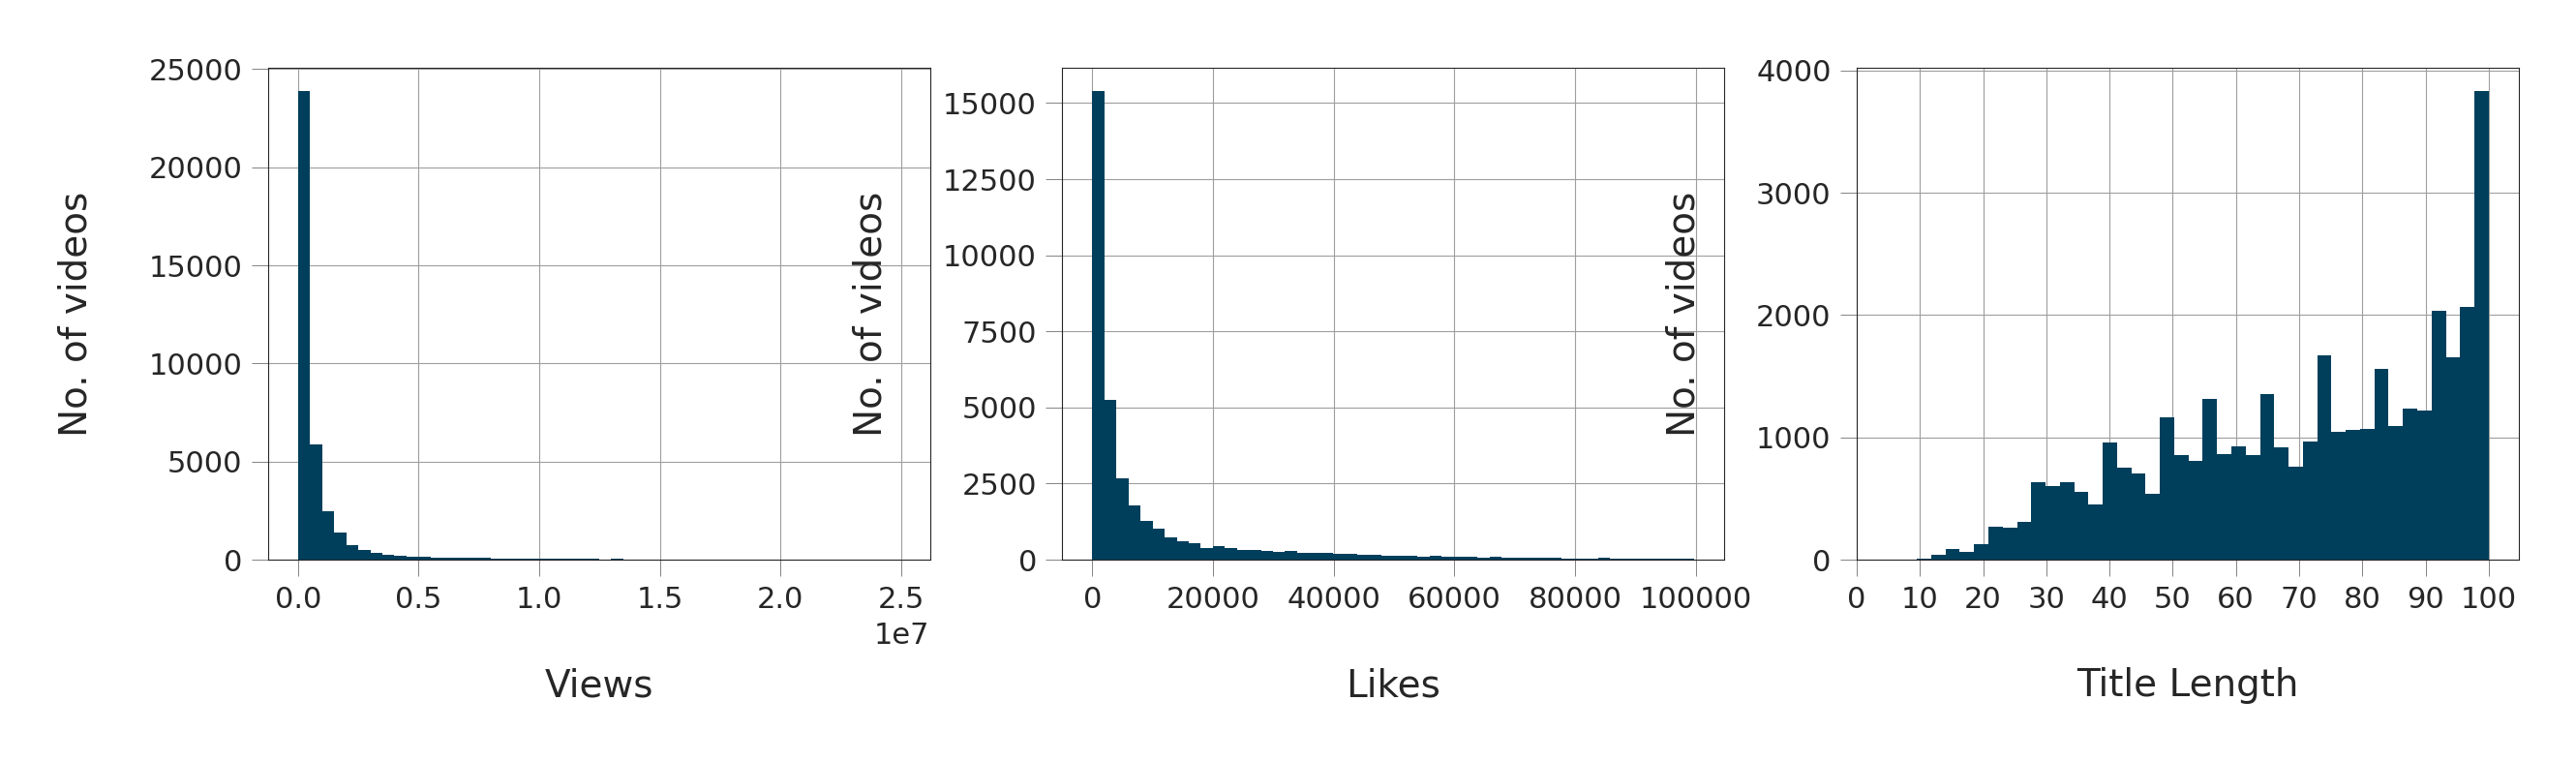

In [ ]:
df["title_length"] = df["title"].apply(lambda x: len(x))
fig, axes = plt.subplots(1, 3, figsize=(15, 3.3))
_ = sns.distplot(df[df["views"] < 25e6]["views"], kde=False, color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=axes[0])
_ = axes[0].set(xlabel="Views", ylabel="No. of videos")

_ = sns.distplot(df[df["likes"] <= 1e5]["likes"], kde=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=axes[1])
_ = axes[1].set(xlabel="Likes", ylabel="No. of videos")

_ = sns.distplot(df["title_length"], kde=False, rug=False,
                 color=PLOT_COLORS[4], hist_kws={'alpha': 1}, ax=axes[2])
_ = axes[2].set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, 110, 10))

print("Percentage of video having views less than 1.5m :",(df['views'] < 1.5e6).sum()/ df['views'].count() * 100)
print("Percentage of video having likes less than 100k :",(df['likes'] < 10e4).sum() / df['likes'].count() * 100)



In [ ]:
df.describe(include = ['O'])

,video_id,trending_date,title,channel_title,publish_time,tags,thumbnail_link,description
count,37352,37352,37352,37352,37352,37352,37352,37352
unique,16307,205,16721,1426,16339,12578,16523,13993
top,#NAME?,17.14.11,Mission: Impossible - Fallout (2018) - Officia...,VikatanTV,2018-04-21T13:30:01.000Z,[none],https://i.ytimg.com/vi/rRr1qiJRsXk/default.jpg,
freq,511,200,19,284,18,1381,16,561


In [ ]:
grouped = df.groupby("video_id")
groups = []
wanted_groups = []
for key, item in grouped:
    groups.append(grouped.get_group(key))

for g in groups:
    if len(g['title'].unique()) != 1:
        wanted_groups.append(g)

wanted_groups[0]

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,title_length
134,#NAME?,17.14.11,స‌మంత కంట‌త‌డి | Samantha became EMOTIONAL @ S...,Friday Poster,24,2017-11-13T08:59:27.000Z,"స‌మంత కంట‌త‌డి|""Samantha became EMOTIONAL @ Sa...",31052,36,11,2,https://i.ytimg.com/vi/-b0ww7L2MGU/default.jpg,False,False,False,స‌మంత కంట‌త‌డి | Samantha became EMOTIONAL @ S...,88
173,#NAME?,17.14.11,कुंभ राशि वालों के लिए 12 नवंबर - 18 नवंबर का ...,Jansatta,25,2017-11-11T09:09:06.000Z,"कुंभ राशि|""Astro""|""rashi""|""कुंभ""|""jansatta""",30659,180,36,3,https://i.ytimg.com/vi/-BcG_jN6DgE/default.jpg,False,False,False,,52
189,#NAME?,17.14.11,"घर में चुपचाप यहाँ रख दे एक लौंग , इतना बरसेगा...",Health Tips for You,26,2017-11-08T12:27:17.000Z,"tona totka|""tone""|""laal kitaab""|""lal kitaab""|""...",743321,2570,1154,294,https://i.ytimg.com/vi/-kj6W27Jj-8/default.jpg,False,False,False,"घर में चुपचाप यहाँ रख दे एक लौंग , इतना बरसेगा...",74
298,#NAME?,17.15.11,18 नवम्बर 2017शनि अमावस्या को जरा से काले तिल ...,AstroMitram,22,2017-11-14T05:41:47.000Z,"Tiger Zinda Hai Trailer|""Tiger Zinda Hai Offic...",28816,376,31,29,https://i.ytimg.com/vi/-X33hZ1oTXI/default.jpg,False,False,False,शनि अमावस्या 18 नवम्बर 2017 को जरा से काले तिल...,100
360,#NAME?,17.15.11,BEST MOM EVER- Things you would love to hear f...,Old Delhi Films,24,2017-11-14T06:52:06.000Z,"Mother|""mom""|""best mom""|""best dad ever""|""best ...",14529,1018,131,83,https://i.ytimg.com/vi/-x9Bp5lFyM0/default.jpg,False,False,False,"Things your MOTHER will never say, still you r...",66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37136,#NAME?,18.13.06,#DeepthiSunaina Cheema joke chepthe navvali..N...,Star Maa,24,2018-06-12T05:44:19.000Z,"comedy|""action""|""entertainment""|""telugu""|""toll...",675923,4642,908,920,https://i.ytimg.com/vi/-fKW38f_0Hk/default.jpg,False,False,False,#BiggBossTelugu2,96
37194,#NAME?,18.14.06,#DeepthiSunaina Cheema joke chepthe navvali..N...,Star Maa,24,2018-06-12T05:44:19.000Z,"comedy|""action""|""entertainment""|""telugu""|""toll...",1014376,5974,1414,1132,https://i.ytimg.com/vi/-fKW38f_0Hk/default.jpg,False,False,False,#BiggBossTelugu2,96
37202,#NAME?,18.14.06,Dumbo Official Teaser Trailer,Disney Movie Trailers,1,2018-06-13T07:00:00.000Z,"Disney|""Walt Disney Studios""|""Dumbo""|""Flying E...",4427381,96391,5508,12726,https://i.ytimg.com/vi/-QPdRfqTnt4/default.jpg,False,False,False,Watch the teaser trailer for Tim Burton’s all-...,29
37316,#NAME?,18.14.06,#DeepthiSunaina Cheema joke chepthe navvali..N...,Star Maa,24,2018-06-12T05:44:19.000Z,"comedy|""action""|""entertainment""|""telugu""|""toll...",1014376,5974,1414,1132,https://i.ytimg.com/vi/-fKW38f_0Hk/default.jpg,False,False,False,#BiggBossTelugu2,96


,proportion
contains_capitalized,
False,0.60
True,0.40


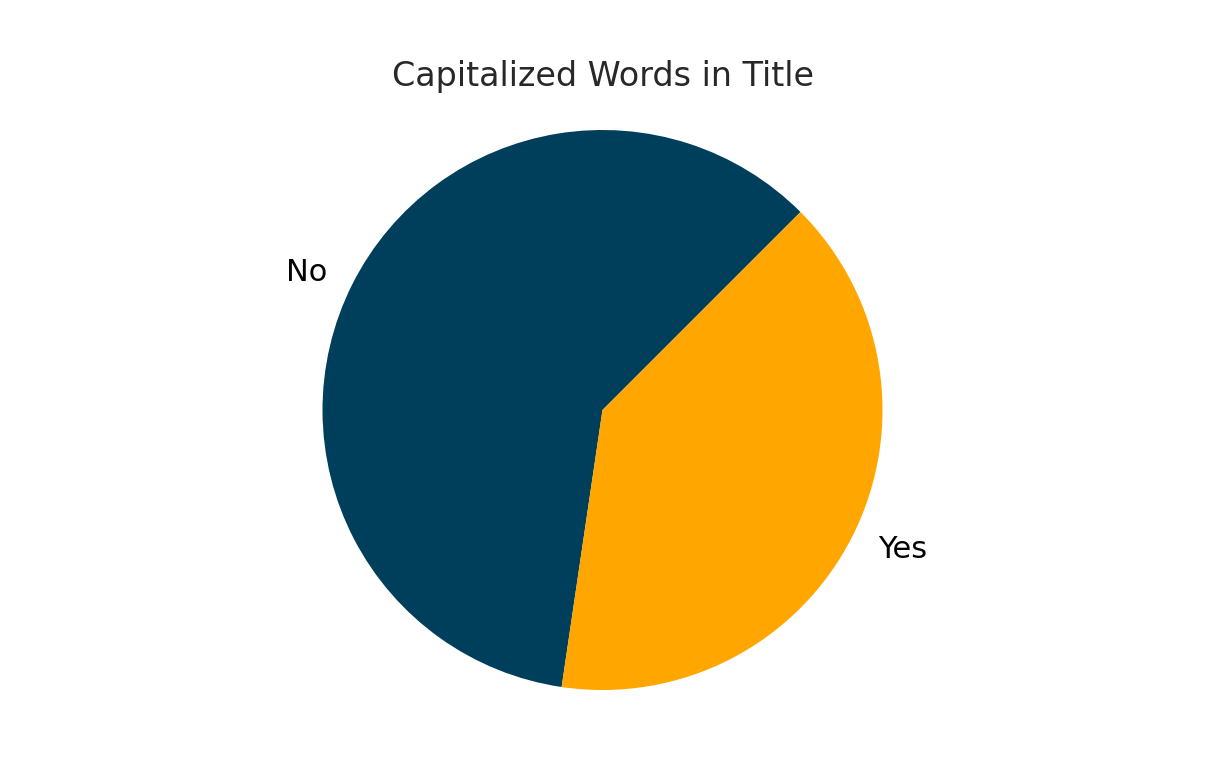

In [ ]:
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False


df["contains_capitalized"] = df["title"].apply(contains_capitalized_word)

value_counts = df["contains_capitalized"].value_counts().to_dict()
fig, ax = plt.subplots(figsize=(7, 4))
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'],
           colors=[PLOT_COLORS[4], '#ffa600'], textprops={'color': '#040204'}, startangle=45)
_ = ax.axis('equal')
_ = ax.set(title="Capitalized Words in Title")

df["contains_capitalized"].value_counts(normalize=True)

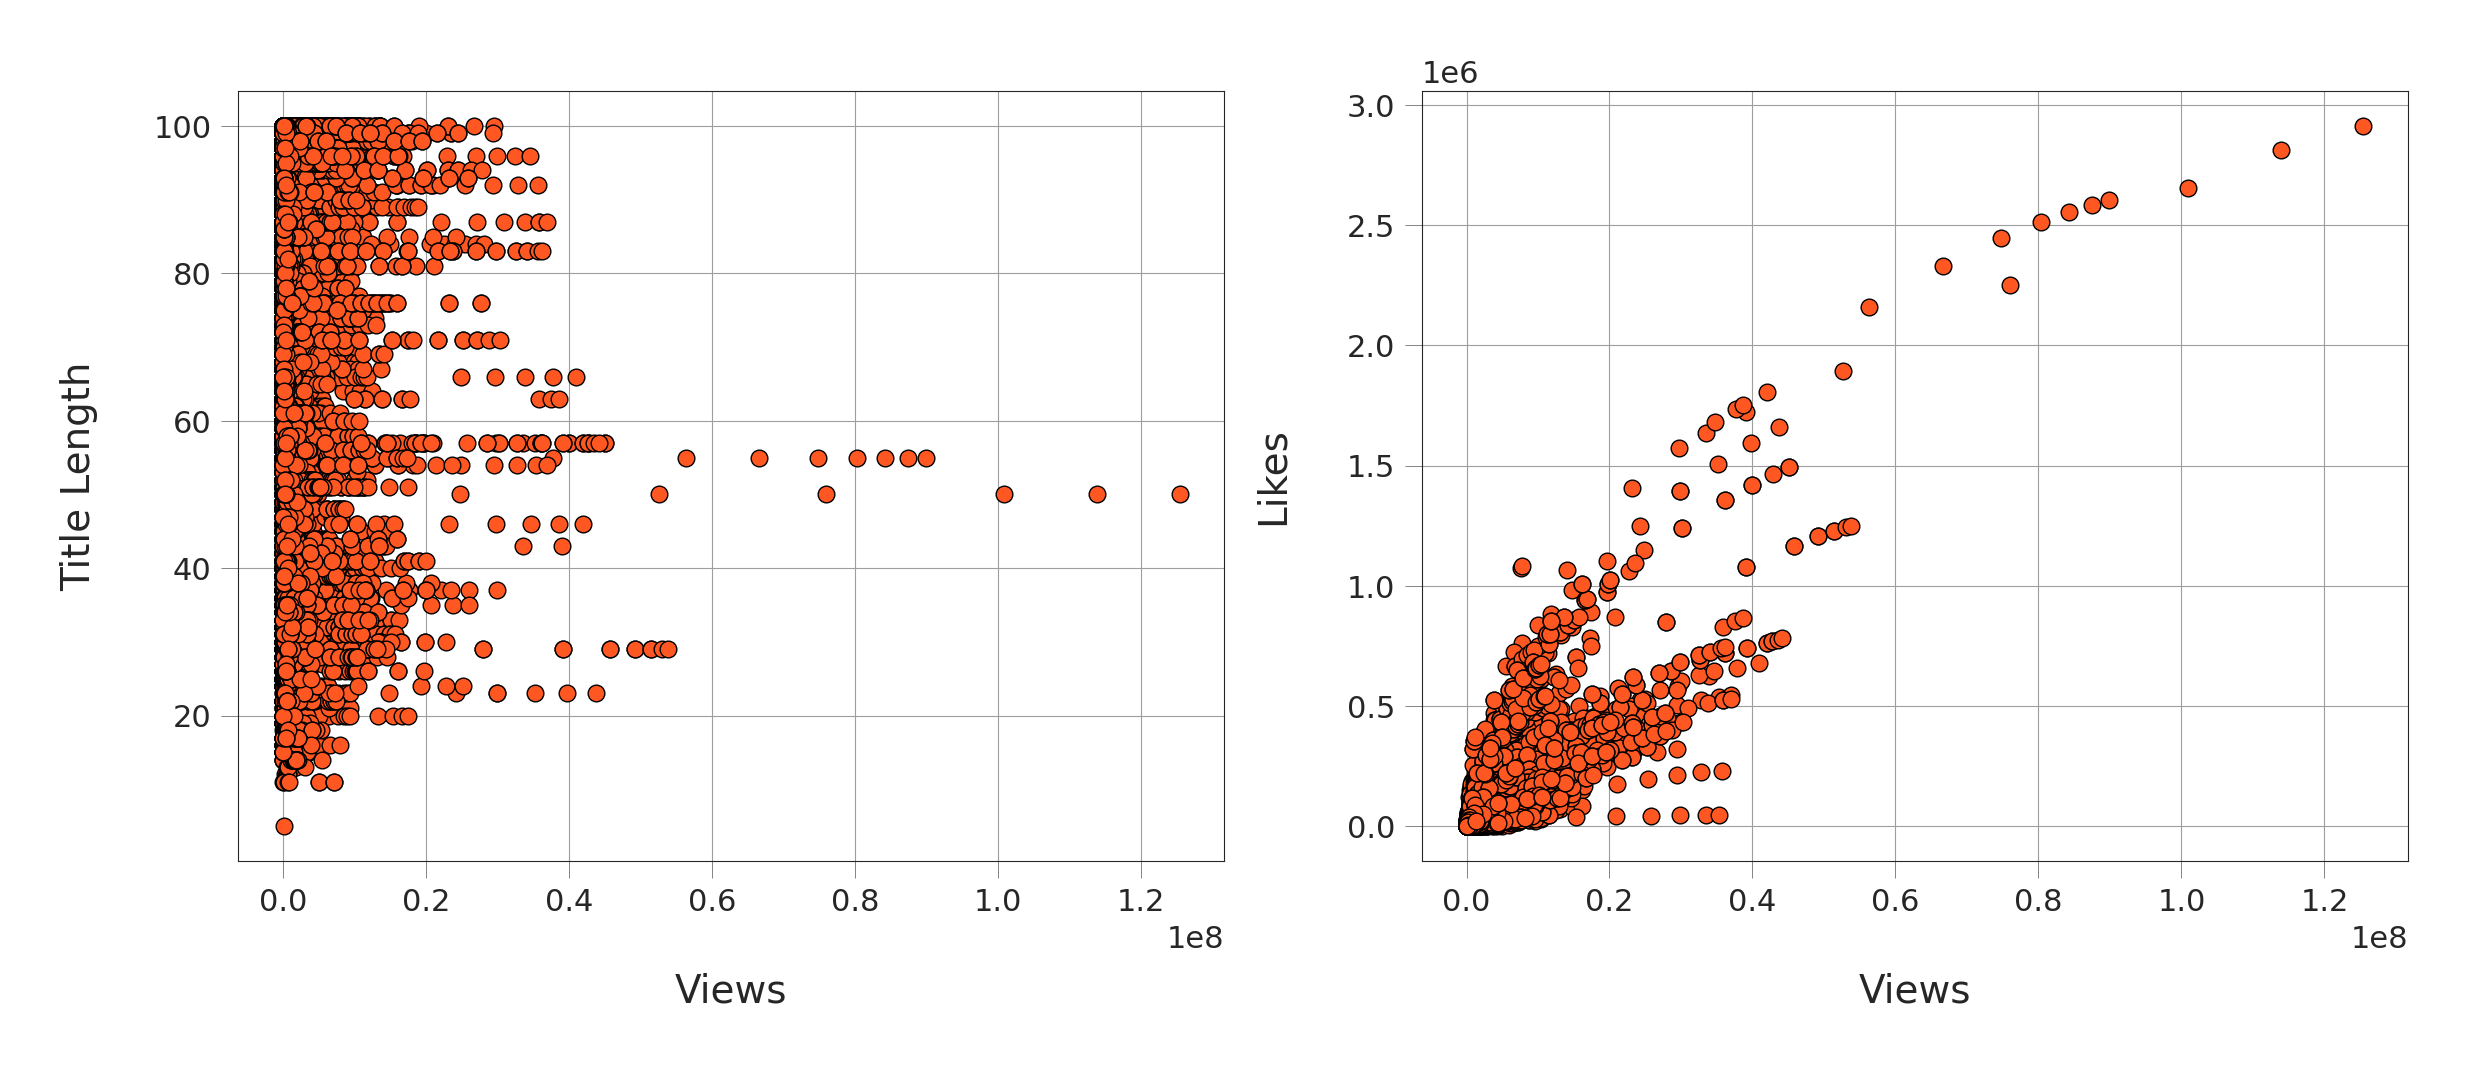

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(x=df['views'], y=df['title_length'], color=PLOT_COLORS[2], edgecolors="#000000", linewidths=0.5)
axes[0].set(xlabel="Views", ylabel="Title Length")
axes[1].scatter(x=df['views'], y=df['likes'], color=PLOT_COLORS[2], edgecolors="#000000", linewidths=0.5)
axes[1].set(xlabel="Views", ylabel="Likes")
plt.show()

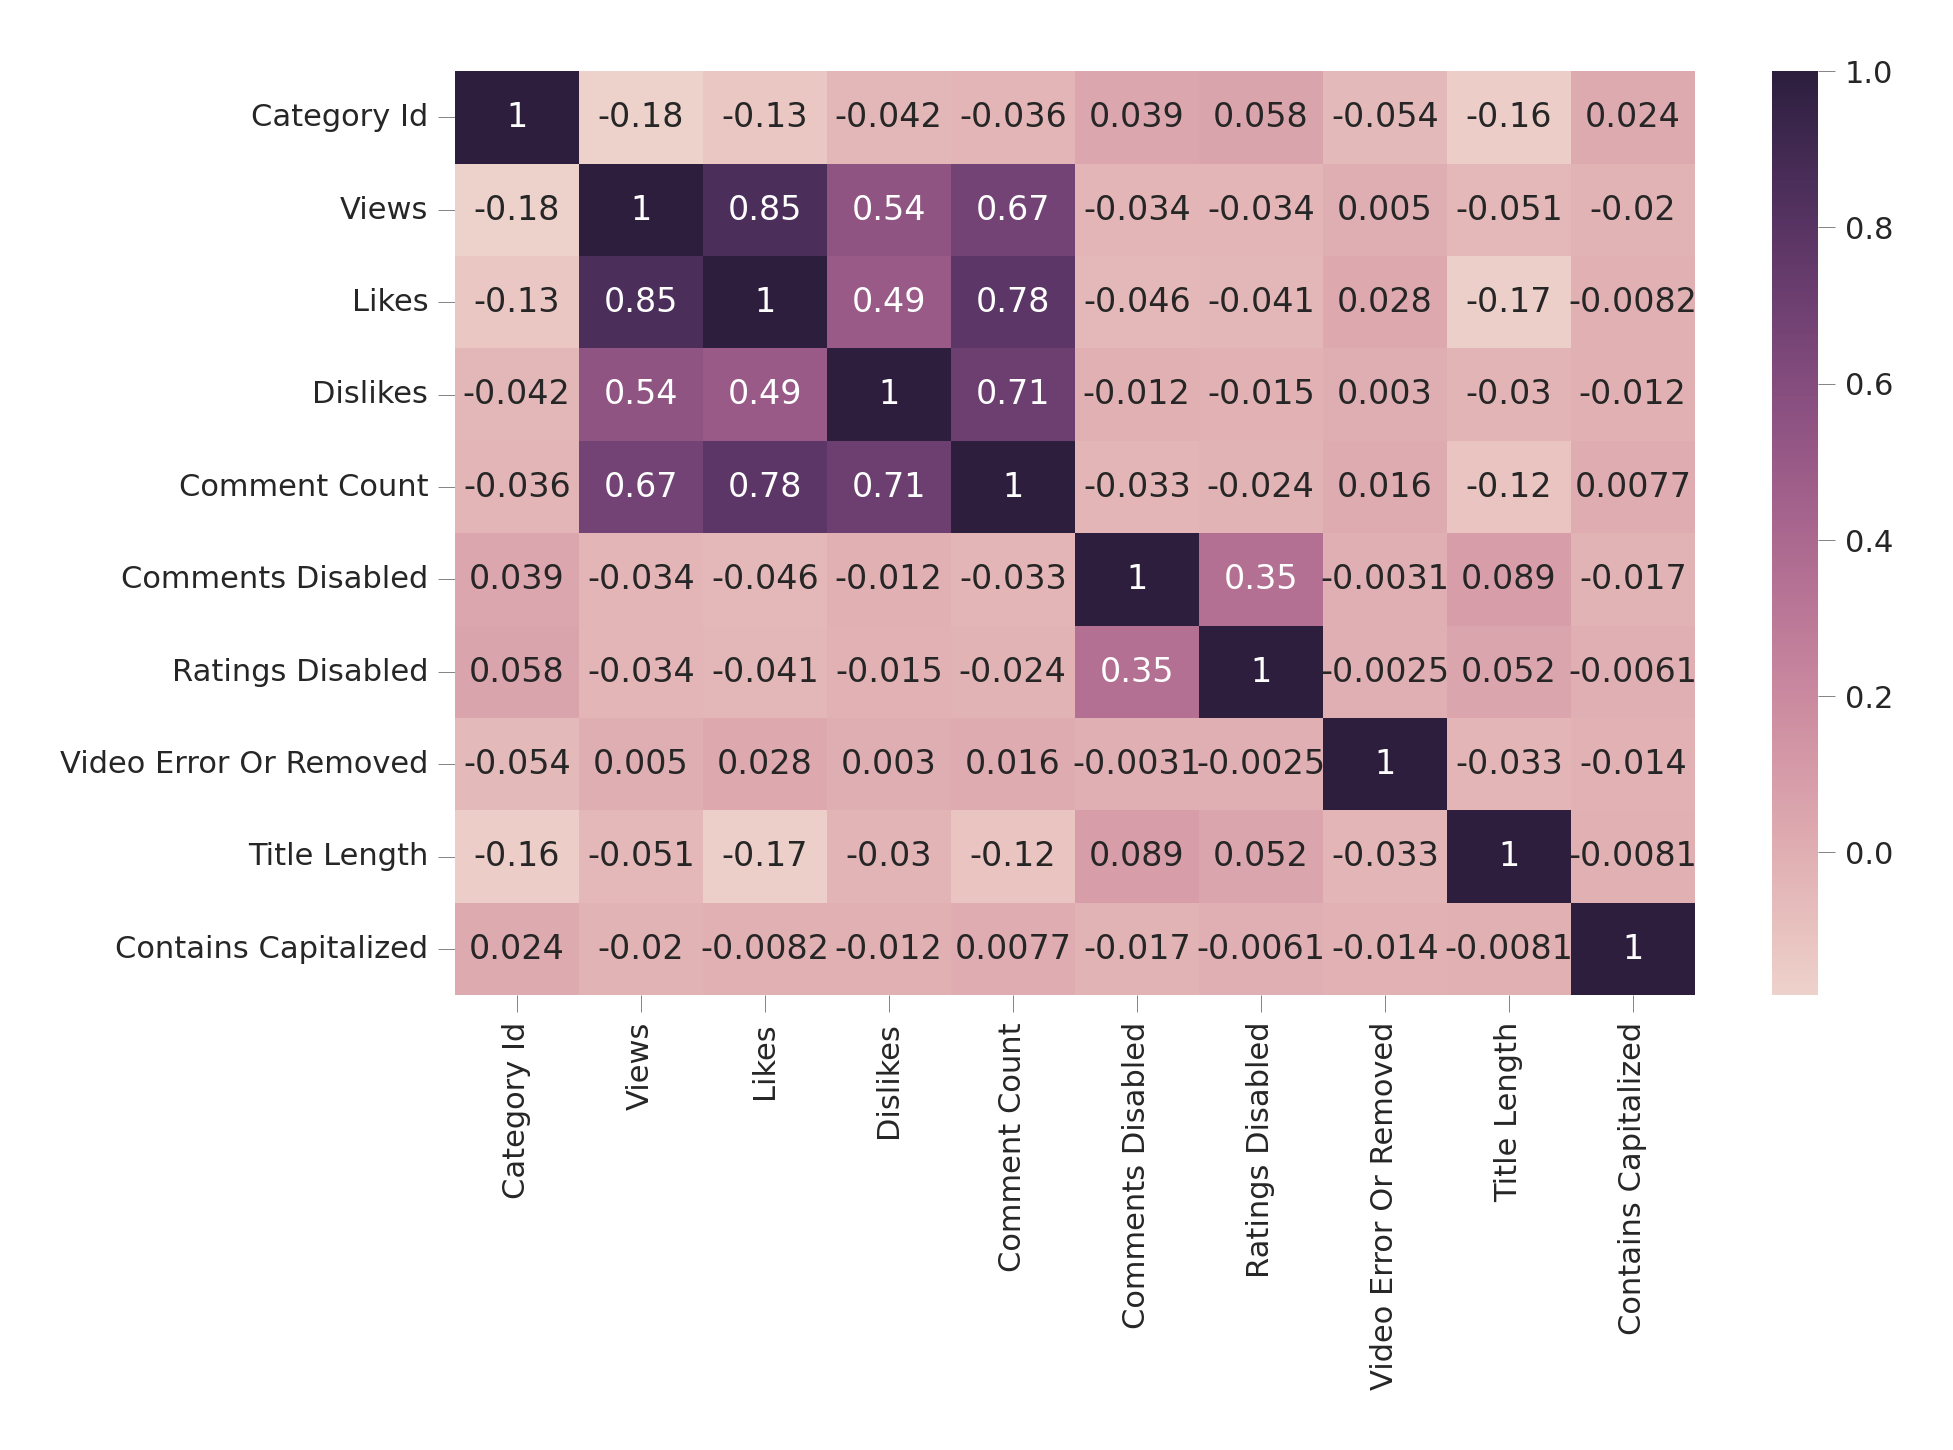

In [ ]:
numerical_df = df.select_dtypes(include=['number', 'bool'])


h_labels = [x.replace('_', ' ').title() for x in list(numerical_df.columns.values)]
numerical_df['video_error_or_removed'] = numerical_df['video_error_or_removed'].astype(int)
fig, ax = plt.subplots(figsize=(10,6))
_ = sns.heatmap(numerical_df.corr(), annot=True, xticklabels=h_labels,
                yticklabels=h_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

In [ ]:
title_words = list(df["title"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(27)

[('|', 41986),
 ('-', 15777),
 ('2018', 6790),
 ('Episode', 4162),
 ('||', 3713),
 ('Full', 1940),
 ('The', 1890),
 ('Movie', 1854),
 ('Song', 1836),
 ('2017', 1693),
 ('Telugu', 1676),
 ('News', 1613),
 ('&', 1601),
 ('Video', 1594),
 ('Latest', 1437),
 ('Official', 1392),
 ('Trailer', 1306),
 ('to', 1306),
 (':', 1293),
 ('in', 1248),
 ('Songs', 1149),
 ('2', 1143),
 ('New', 1137),
 ('May', 1075),
 ('Punjabi', 1037),
 ('TV', 1018),
 ('की', 986)]

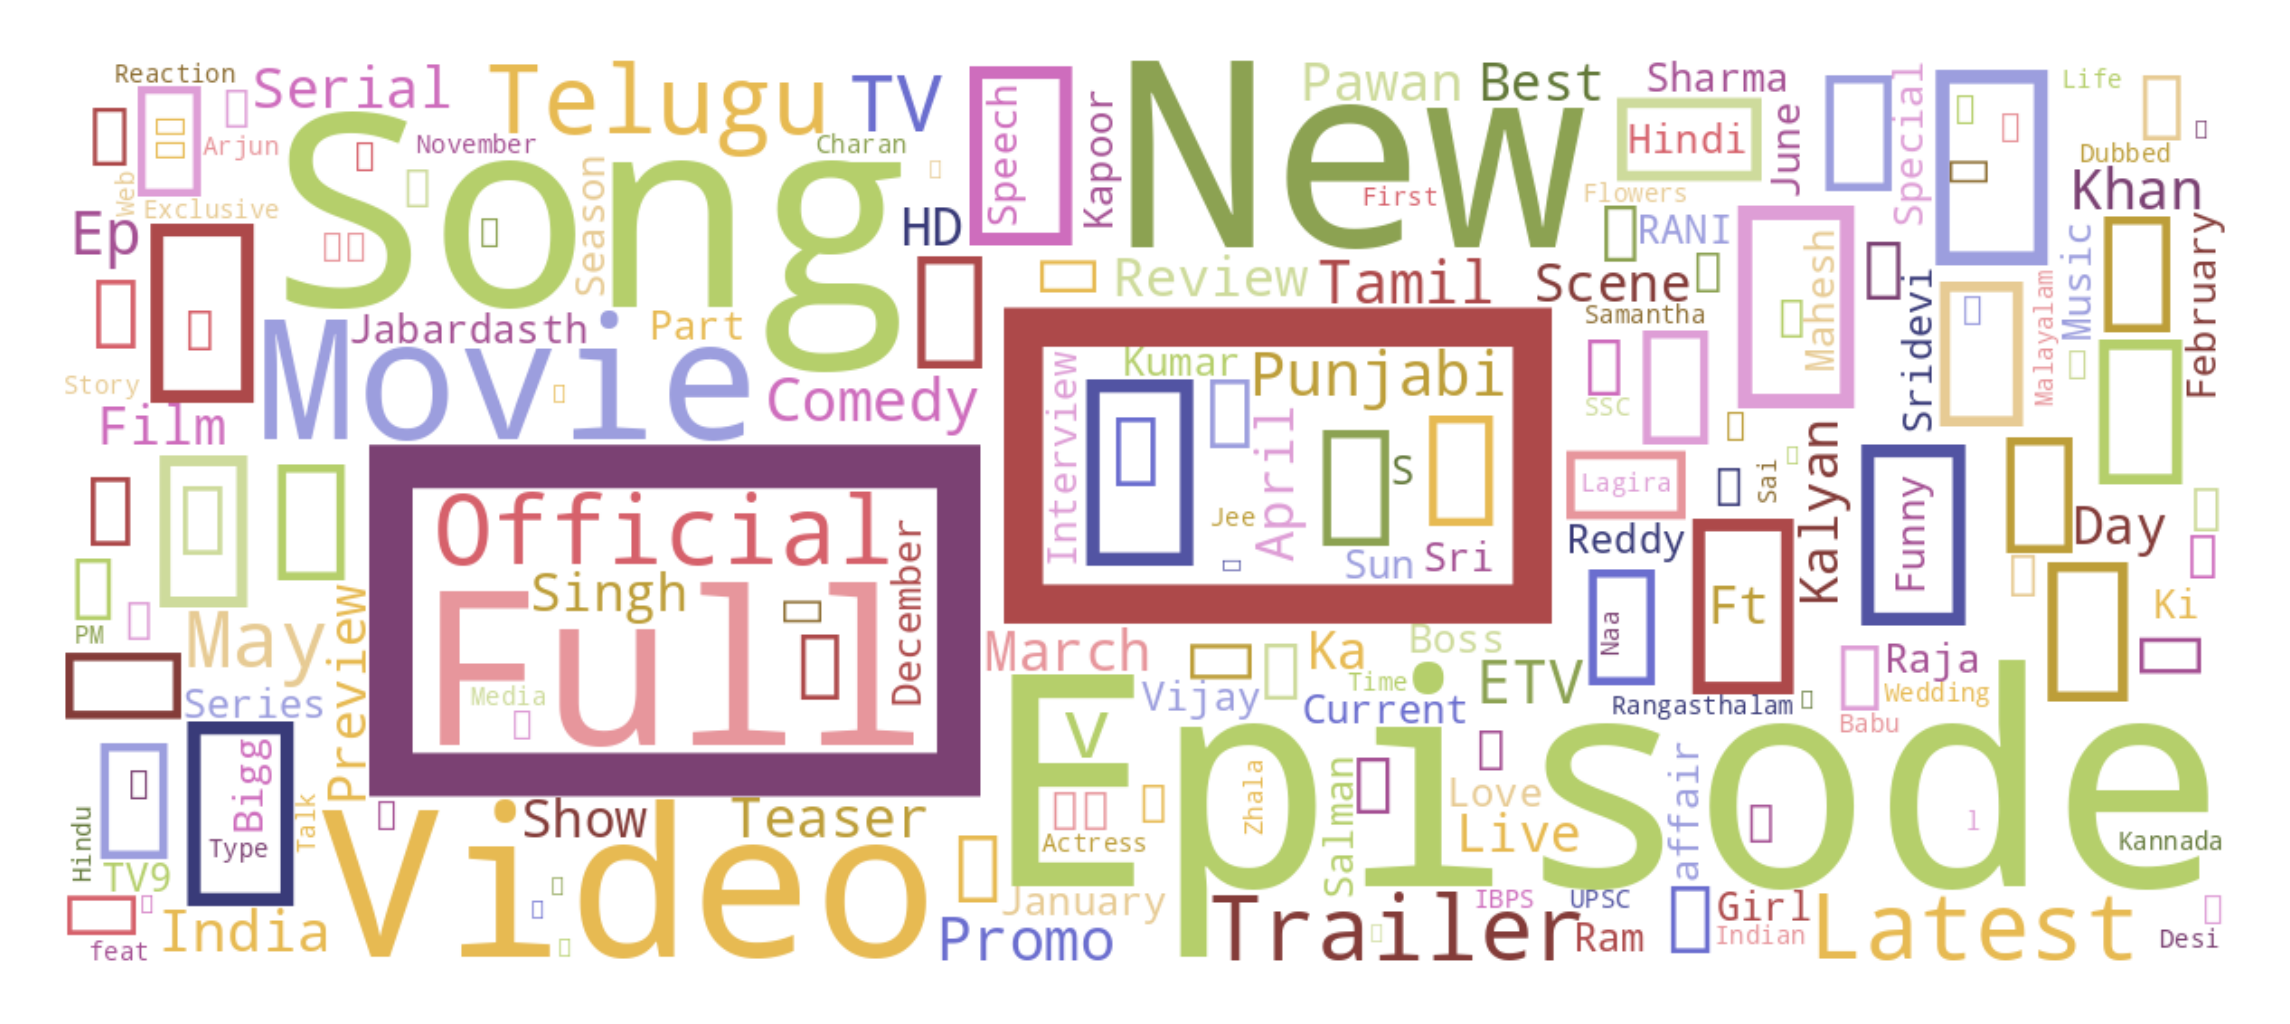

In [ ]:
wc = wordcloud.WordCloud(width=1200, height=500,
                         collocations=False, background_color="white",
                         colormap="tab20b").generate(" ".join(title_words))
plt.figure(figsize=(14,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")



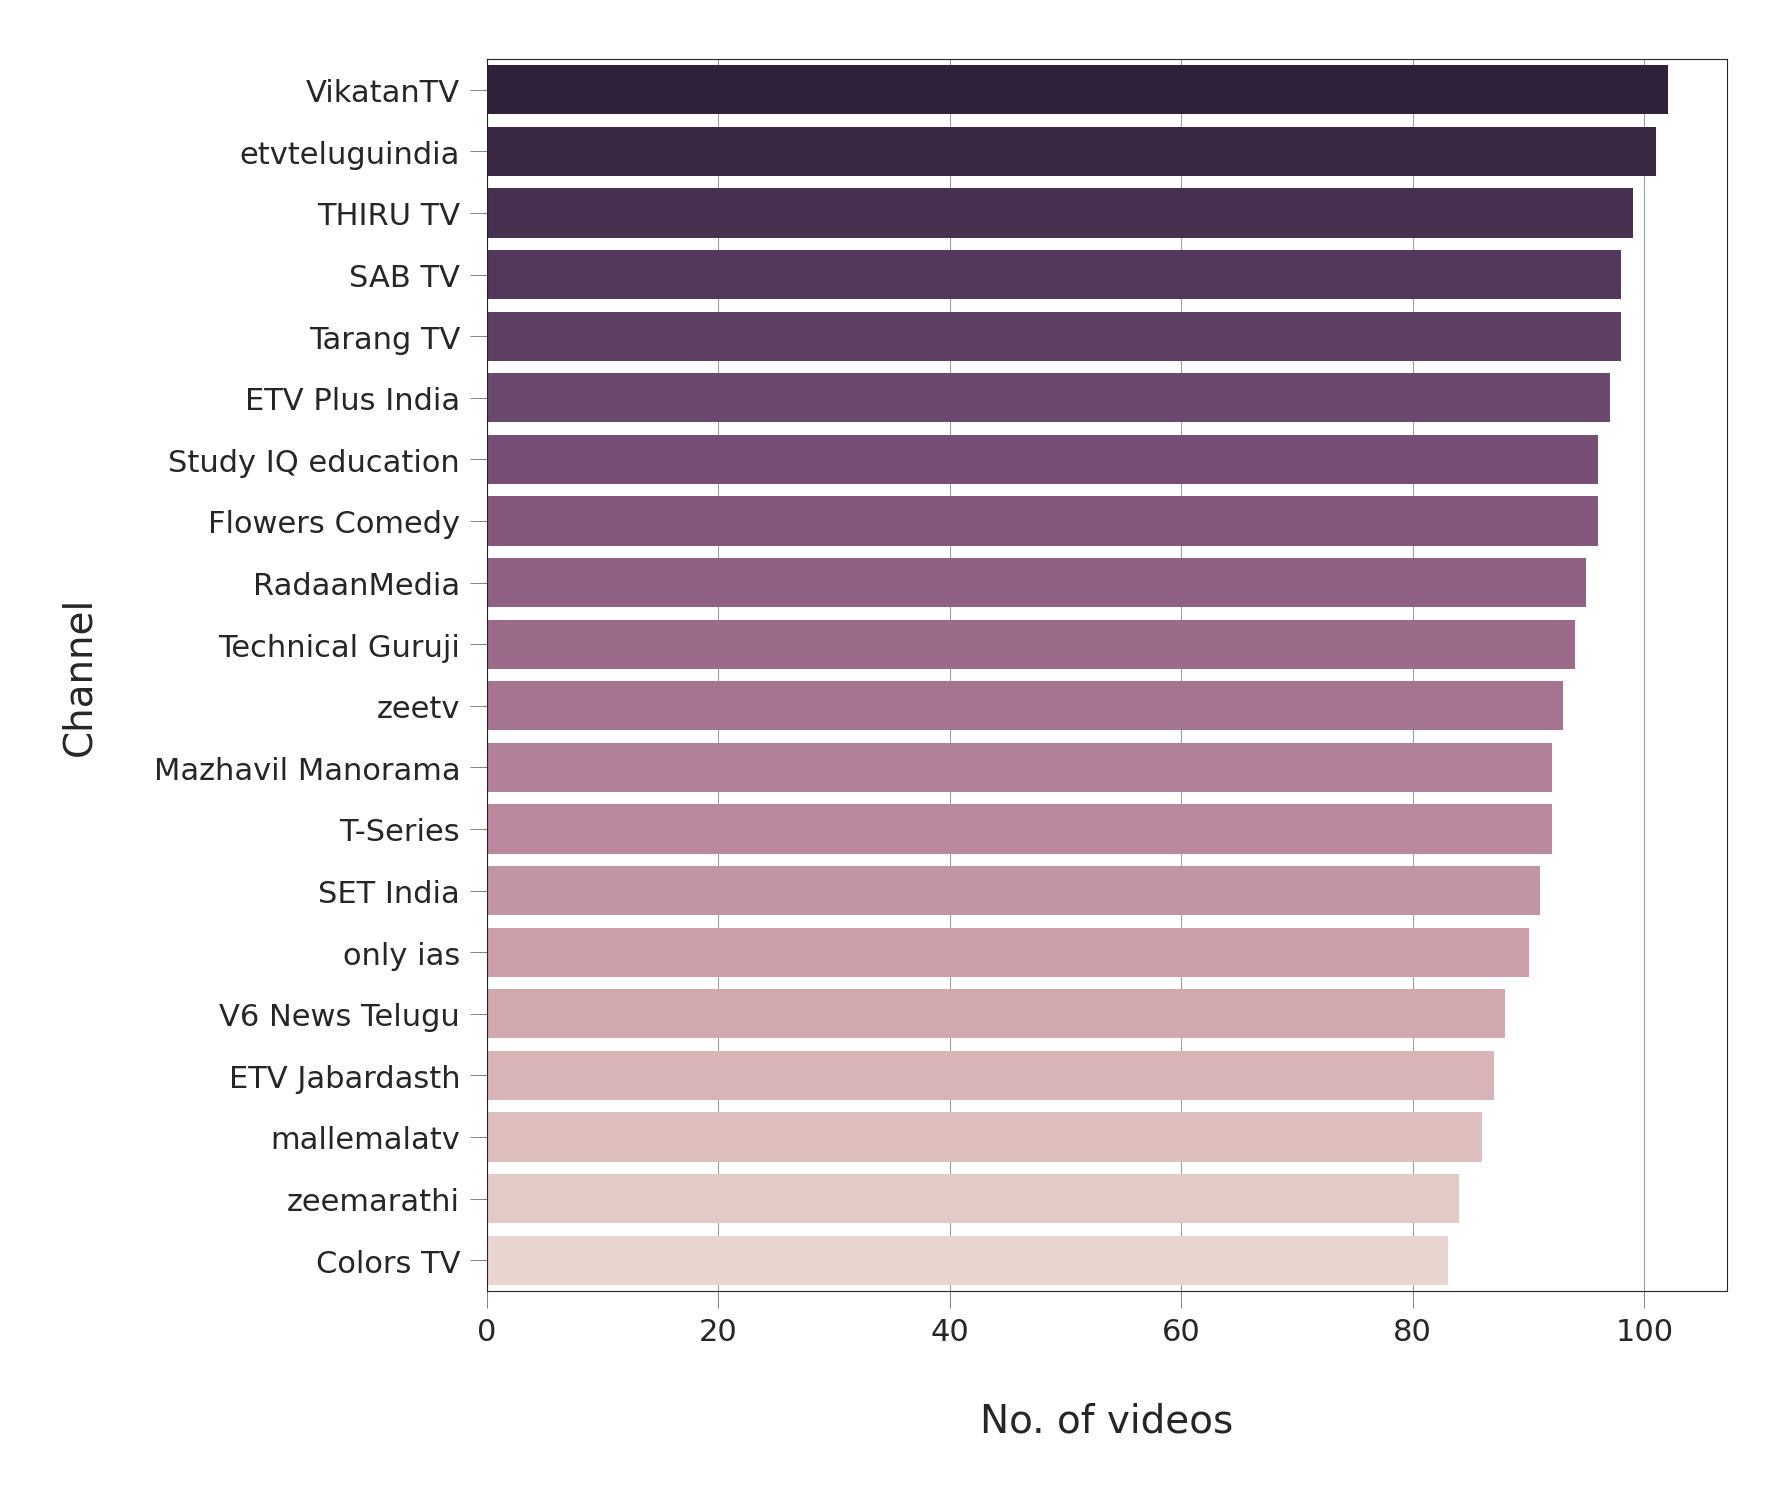

In [ ]:
cdf = df.groupby("channel_title").size().reset_index(name="video_count") \
    .sort_values("video_count", ascending=False).head(20)

fig, ax = plt.subplots(figsize=(8,8))
_ = sns.barplot(x="video_count", y="channel_title", data=cdf,
                palette=sns.cubehelix_palette(n_colors=20, reverse=True), ax=ax)
_ = ax.set(xlabel="No. of videos", ylabel="Channel")

The category with the largest number of trending videos is 'Entertainment' with 16712 videos.


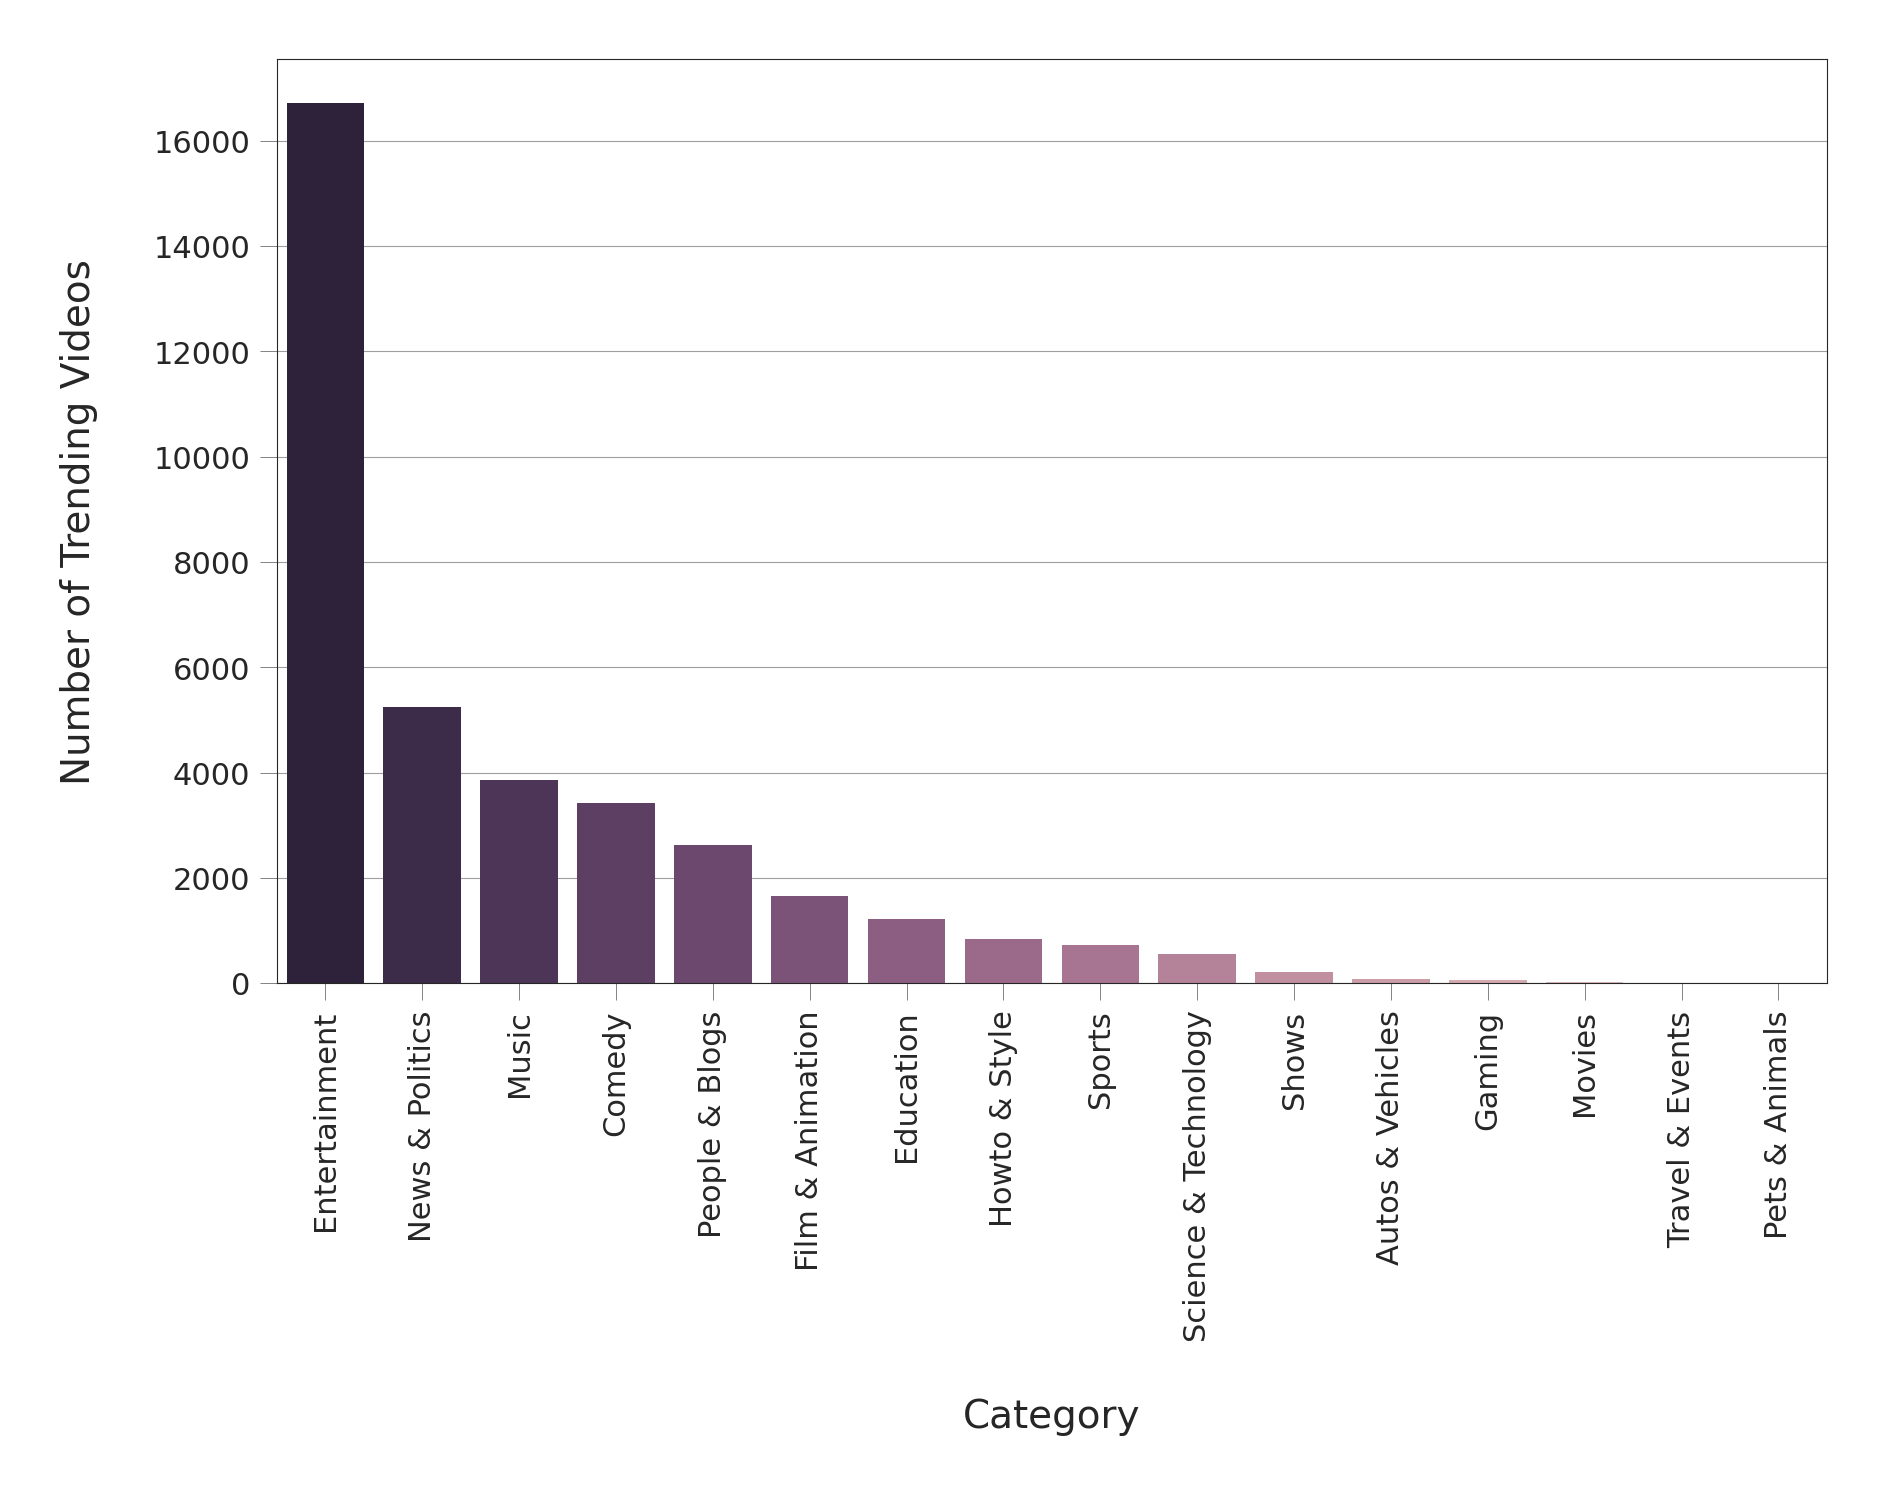

In [ ]:
with open("/content/IN_category_id.json") as file:
    categories = json.load(file)["items"]
cat_dict = {}
for cat in categories:
    cat_dict[int(cat["id"])] = cat["snippet"]["title"]
df['category_name'] = df['category_id'].map(cat_dict)

category_trending_counts = df.groupby('category_name')['video_id'].count().reset_index()
category_trending_counts.rename(columns={'video_id': 'trending_count'}, inplace=True)

category_trending_counts = category_trending_counts.sort_values('trending_count', ascending=False)

top_category = category_trending_counts.iloc[0]['category_name']
top_category_count = category_trending_counts.iloc[0]['trending_count']

print(f"The category with the largest number of trending videos is '{top_category}' with {top_category_count} videos.")

fig, ax = plt.subplots(figsize=(10, 6))
_ = sns.barplot(x="category_name", y="trending_count", data=category_trending_counts,
                palette=sns.cubehelix_palette(n_colors=len(category_trending_counts), reverse=True), ax=ax)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
_ = ax.set(xlabel="Category", ylabel="Number of Trending Videos")
plt.show()

# ML

In [ ]:
df_model = pd.read_csv("/content/INvideos.csv")

df_model = df_model.drop(columns=["video_id", "trending_date", "thumbnail_link"])

bool_cols = ["comments_disabled", "ratings_disabled", "video_error_or_removed"]
for col in bool_cols:
    if col in df_model.columns:
        df_model[col] = df_model[col].astype(int)


tfidf = TfidfVectorizer(max_features=500)
df_model["title_tfidf"] = list(tfidf.fit_transform(df_model["title"].fillna(" ")).toarray())
df_model["desc_tfidf"] = list(tfidf.fit_transform(df_model["description"].fillna(" ")).toarray())

df_model = df_model.drop(columns=["category_id","title", "description", "tags", "channel_title"])

df_model["publish_time"] = pd.to_datetime(df_model["publish_time"], errors='coerce')
df_model["publish_hour"] = df_model["publish_time"].dt.hour
df_model["publish_day"] = df_model["publish_time"].dt.day
df_model["publish_month"] = df_model["publish_time"].dt.month
df_model = df_model.drop(columns=["publish_time"])

features_classification = [ "likes", "dislikes", "comment_count", "comments_disabled", "ratings_disabled", "publish_hour", "publish_day", "publish_month"]
df_model["trending"] = (df_model["likes"] > df_model["likes"].median()).astype(int)
X_classification = df_model[features_classification]
y_classification = df_model["trending"]

features_regression = [ "likes", "dislikes", "comment_count", "comments_disabled", "ratings_disabled", "publish_hour", "publish_day", "publish_month"]
X_regression = df_model[features_regression]
y_regression = df_model["views"]

scaler = StandardScaler()
X_classification = scaler.fit_transform(X_classification)
X_regression = scaler.fit_transform(X_regression)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_classification, y_classification, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_regression, y_regression, test_size=0.2, random_state=42)

xgb_cls = xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_cls.fit(X_train_cls, y_train_cls)
y_pred_cls = xgb_cls.predict(X_test_cls)
accuracy = accuracy_score(y_test_cls, y_pred_cls)
print(f'Classification Accuracy (XGBoost): {accuracy:.4f}')


lr = LinearRegression()
lr.fit(X_train_reg, y_train_reg)
y_pred_lr = lr.predict(X_test_reg)

xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42)
xgb_reg.fit(X_train_reg, y_train_reg)
y_pred_xgb = xgb_reg.predict(X_test_reg)


mae_lr = mean_absolute_error(y_test_reg, y_pred_lr)
mse_lr = mean_squared_error(y_test_reg, y_pred_lr)
r2_lr = r2_score(y_test_reg, y_pred_lr)
print(f'Linear Regression - MAE: {mae_lr:.2f}, MSE: {mse_lr:.2f}, R2: {r2_lr:.4f}')

mae_xgb = mean_absolute_error(y_test_reg, y_pred_xgb)
mse_xgb = mean_squared_error(y_test_reg, y_pred_xgb)
r2_xgb = r2_score(y_test_reg, y_pred_xgb)
print(f'XGBoost Regression - MAE: {mae_xgb:.2f}, MSE: {mse_xgb:.2f}, R2: {r2_xgb:.4f}')



Classification Accuracy (XGBoost): 0.9988
Linear Regression - MAE: 648135.17, MSE: 2736957767290.50, R2: 0.7582
XGBoost Regression - MAE: 328028.81, MSE: 739557441536.00, R2: 0.9347


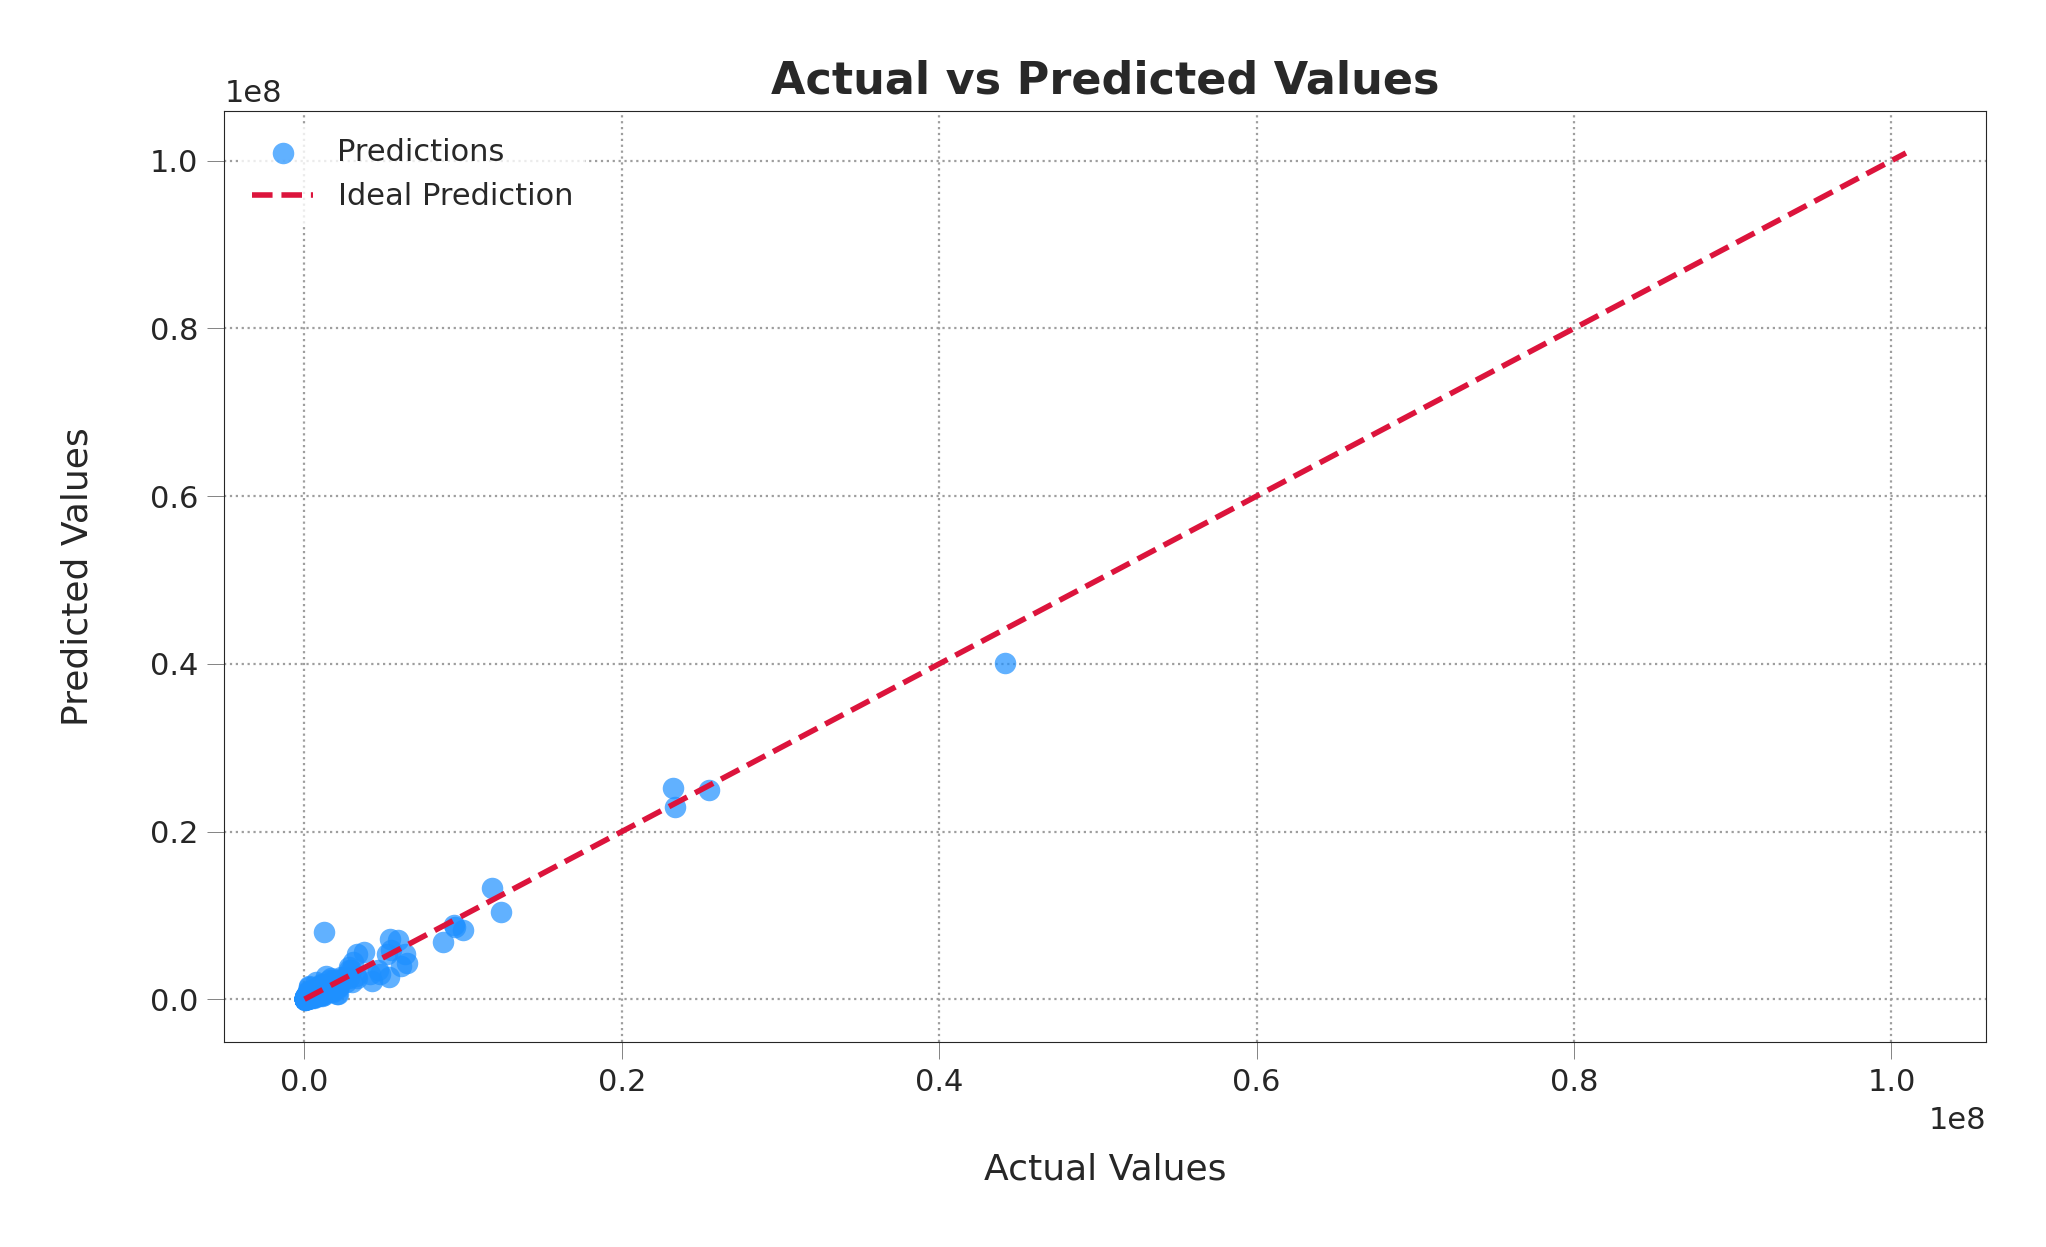

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test[:500], y_pred[:500], alpha=0.7, c='dodgerblue', edgecolors='black', s=60, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'crimson', linestyle='--', linewidth=2, label='Ideal Prediction')

plt.title("Actual vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Actual Values", fontsize=13)
plt.ylabel("Predicted Values", fontsize=13)
plt.grid(True, linestyle=':', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def predict_video():
    likes = int(input("Enter Likes: "))
    dislikes = int(input("Enter Dislikes: "))
    comment_count = int(input("Enter Comment Count: "))
    comments_disabled = int(input("Comments Disabled (1 for Yes, 0 for No): "))
    ratings_disabled = int(input("Ratings Disabled (1 for Yes, 0 for No): "))
    publish_hour = int(input("Enter Publish Hour (0-23): "))
    publish_day = int(input("Enter Publish Day (1-31): "))
    publish_month = int(input("Enter Publish Month (1-12): "))

    input_data = np.array([[likes, dislikes, comment_count, comments_disabled, ratings_disabled, publish_hour, publish_day, publish_month]])
    input_data = scaler.transform(input_data)
    trending_prediction = xgb_cls.predict(input_data)[0]
    view_count_prediction = xgb_reg.predict(input_data)[0]

    trending_result = "Trending" if trending_prediction == 1 else "Not Trending"
    print(f"Predicted Trend: {trending_result}")
    print(f"Predicted Views: {view_count_prediction:.0f}")


predict_video()

Enter Likes: 100000
Enter Dislikes: 210
Enter Comment Count: 350
Comments Disabled (1 for Yes, 0 for No): 0
Ratings Disabled (1 for Yes, 0 for No): 0
Enter Publish Hour (0-23): 16
Enter Publish Day (1-31): 5
Enter Publish Month (1-12): 7
Predicted Trend: Trending
Predicted Views: 1480679
